# Identifying type of opinions in spanish wikipedia discussions 

In this analysis, we are going to automatically identify the kind of opinion of authors in the discussions on talk pages of spanish wikipedia.

In [29]:
import pandas as pd
import numpy as np
import os
import gc
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
matplotlib.style.use('seaborn-ticks')
matplotlib.rcParams['font.size'] = 14
matplotlib.rcParams['legend.fontsize'] = 14
matplotlib.rcParams['ytick.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 14
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['axes.titlesize'] = 18
sns.set_style("ticks")

In [2]:
ds = pd.read_csv('data/wdds.csv')
ds.shape

(2097, 20)

remove unnecesary label 'discusión' in title

In [3]:
ds['page_title'] = ds.page_title.str.replace('Discusión:', '')

In [4]:
print(f'unique authors: {ds.contributor.nunique()}')

unique authors: 387


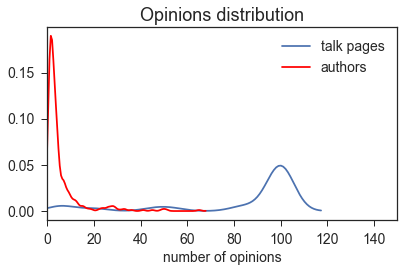

In [37]:
#plt.subplot(2,1,1)
import seaborn as sns


discussion_perpage= ds.groupby('page_title').size()
discussion_pereditor= ds.groupby('contributor').size()

#plt.figure(figsize=(5,3))
sns.kdeplot(discussion_perpage,label='talk pages')
plt.xlabel('number of opinions')
sns.kdeplot(discussion_pereditor,color='red', label='authors')
plt.title('Opinions distribution')
#plt.yscale('log')
plt.xlim([0,150])
plt.tight_layout()
plt.savefig('output/opauthorcontribdist.eps', format='eps')


#plt.savefig('output/opiniontalkpagesdist.eps', format='eps')

In [23]:
import scipy.stats as stats
import scipy
print(stats.normaltest(np.log(discussion_perpage)))
print(scipy.stats.mstats.skew(discussion_perpage))

NormaltestResult(statistic=26.549266604121378, pvalue=1.7175128998289259e-06)
-1.7207740848065967


Most authors have 10 or less opinions.  It could be useful to know if there are authors with opinions in multiple talk pages

In [21]:
discussion_editor=ds.groupby(['contributor', 'page_title']).size().reset_index()
discussion_editor=discussion_editor['contributor'].value_counts()
discussion_editor=discussion_editor.reset_index() #.plot.area()
discussion_editor.columns=['contributors', 'pages']
discussion_editor=discussion_editor.groupby('pages').count().reset_index()
total=discussion_editor.contributors.sum()
discussion_editor['perc'] = discussion_editor.contributors / total
discussion_editor.to_csv('output/articlesauthorcontribdist.csv', index=False)
discussion_editor
# plt.legend([])
# plt.xlabel('number of authors')
# plt.xticks([])
# plt.ylabel('number of talk pages')
# plt.title('Articles contribution by authors')
# plt.savefig('output/articlesauthorcontribdist.eps', format='eps')

,pages,contributors,perc
0,1,358,0.925065
1,2,22,0.056848
2,3,3,0.007752
3,4,2,0.005168
4,7,2,0.005168


Most authors only contribute to one discussions, with few authors contributing to two or more discussions.  